In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from random import randint
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display  import Audio
from sklearn import preprocessing
import seaborn as sns
import missingno as msno
import plotly.graph_objects as go
import warnings
import pickle
warnings.filterwarnings("ignore")
np.random.seed()

# Generacion Cluster

In [4]:
# carga dataset
df_t=pd.read_pickle('dataset_sr_original_mean.pkl')

In [7]:
# Escalado de datos
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#dataset escalado y separado en train y test para entrenar modelos.
df2=df_t.drop(['archivo','Genero','Genero_label'], axis=1).copy()
scaler=StandardScaler()
df_scaled=scaler.fit_transform(df2)
df_scaled=pd.DataFrame(df_scaled, columns=df2.columns.to_list())
df_scaled['archivo']=df_t['archivo']
df_scaled['Genero']=df_t['Genero']
df_scaled['Genero_label']=df_t['Genero_label'] 
df_train,df_test=train_test_split(df_scaled,test_size=0.3, stratify=df_scaled['Genero_label'])
X_train=df_train.drop(['archivo','Genero','Genero_label'], axis=1).copy()
y_train=df_train['Genero_label']
X_test=df_test.drop(['archivo','Genero','Genero_label'], axis=1).copy()
y_test=df_test['Genero_label']

#dataset escalado para cluster kmeans 
df_cluster=df_scaled.drop(['archivo','Genero','Genero_label'], axis=1).copy() 


In [6]:
# función para el metodo del codo y ver numero de clusters recomendados.
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
def elbow_method(data, max_clusters=12):
    sum_of_squared_distances = []
    for k in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)
        sum_of_squared_distances.append(kmeans.inertia_)
    # Graficar la curva del codo
    plt.plot(range(1, max_clusters+1), sum_of_squared_distances, 'bx-')
    plt.xlabel('Número de Clusters (k)')
    plt.ylabel('Suma de las Distancias al Cuadrado')
    plt.title('Curva del Codo')
    plt.show()

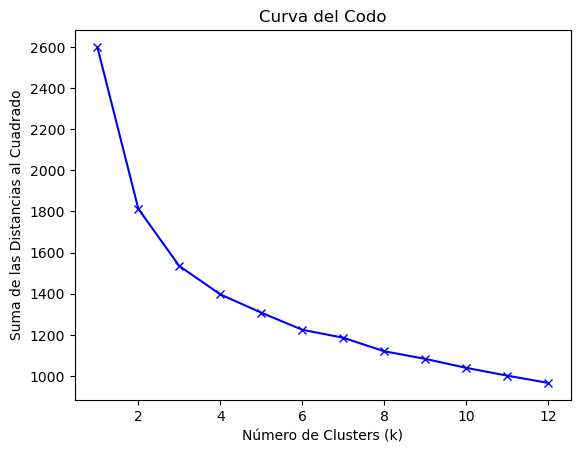

In [108]:
#Calculamos metodo del codo
elbow_method(df_cluster)


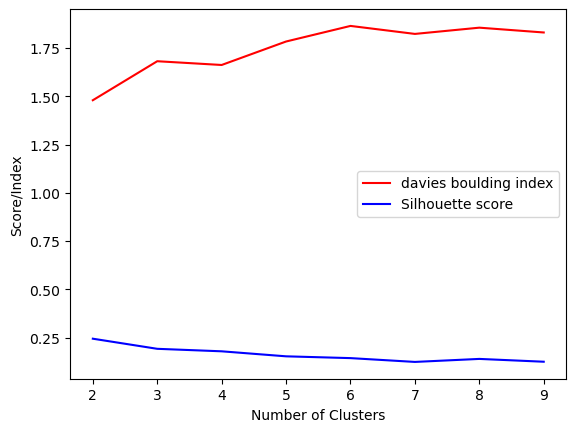

In [109]:
#script para representar coeficiente de silueta y de davies para ver numero de clusters
from sklearn.metrics import davies_bouldin_score, silhouette_score
silhouette_coefficients = []
davies_bouldin_scores = []
# Notice we start at 2 clusters for silhouette coefficient
for k in range(2,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_cluster)
    sil_score = silhouette_score(df_cluster, kmeans.labels_)
    silhouette_coefficients.append(sil_score)
    db_score = davies_bouldin_score(df_cluster, kmeans.labels_)
    davies_bouldin_scores.append(db_score)
 


plt.plot(range(2, 10), davies_bouldin_scores, color='red', label = 'davies boulding index')
plt.plot(range(2, 10), silhouette_coefficients, color='blue', label = 'Silhouette score')
plt.xticks(range(2, 10))

plt.xlabel("Number of Clusters")
plt.ylabel("Score/Index")
plt.legend()
plt.show()

In [244]:
# Cluster Kmeans de los datos
kmeans = KMeans(n_clusters=5, random_state=0).fit(df_cluster)


Text(0.5, 1.0, 'Clustering $K=5$')

<Figure size 800x500 with 0 Axes>

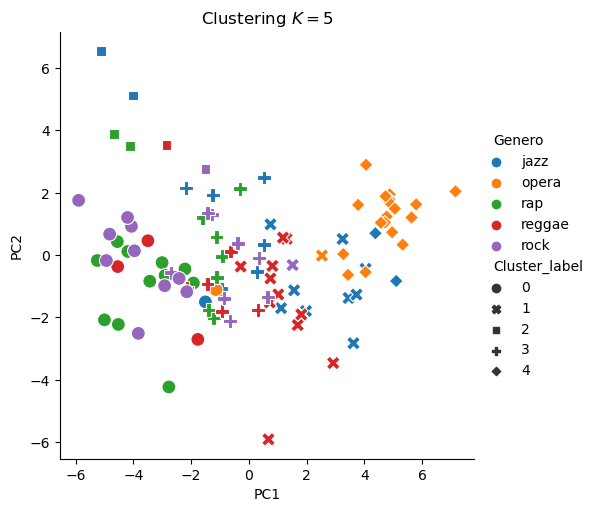

In [93]:
#representación clusters
from sklearn.decomposition import PCA
pca=PCA(n_components=2) 
x=pca.fit_transform(df_cluster)
df_pca2=pd.DataFrame(x,columns=['PC1','PC2'])
df_pca2['Genero']=df_t['Genero']
df_pca2['Genero_label']=df_t['Genero_label']
df_pca2['Cluster_label']=kmeans.labels_
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.relplot(data=df_pca2, x='PC1', y='PC2', hue='Genero', style='Cluster_label', palette="tab10",s =100)
plt.title('Clustering $K=5$')


In [245]:
df_t['kmeans']=kmeans.labels_


In [95]:
print(df_t[df_t['kmeans']==0]['Genero'].unique())
print(df_t[df_t['kmeans']==1]['Genero'].unique())
print(df_t[df_t['kmeans']==2]['Genero'].unique())
print(df_t[df_t['kmeans']==3]['Genero'].unique())
print(df_t[df_t['kmeans']==4]['Genero'].unique())

['jazz' 'opera' 'rap' 'reggae' 'rock']
['jazz' 'opera' 'reggae' 'rock']
['jazz' 'rap' 'reggae' 'rock']
['jazz' 'rap' 'reggae' 'rock']
['jazz' 'opera']


Es complicado asignar una etiqueta a cada grupo ya que el kmeasn no se entrena con una etiqueta dada solo se agrupa por similitud, tan solo la etiqueta 4 podría asignarse a Opera, lo que si podría usarse es para recomendar canciones con similitud de frecuencias, tempo...


In [96]:
df_t.drop('kmeans', axis=1,inplace=True)

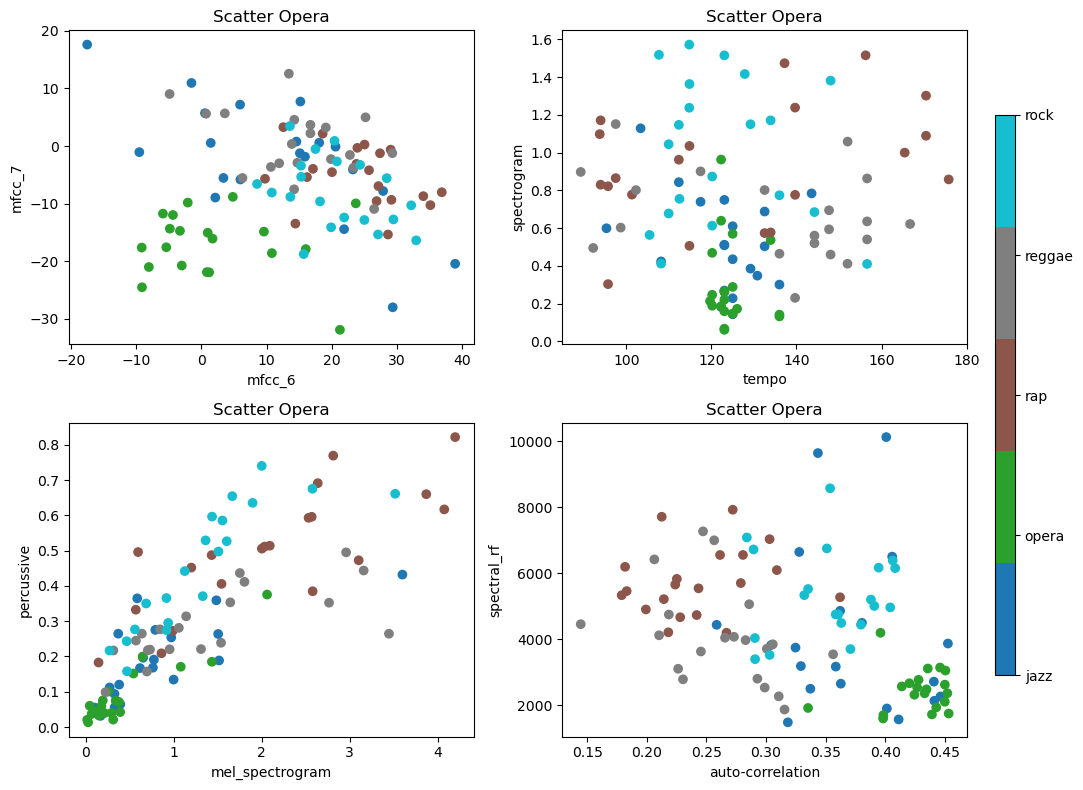

In [138]:
# scatter de diferentes pares de variables
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))


cmap = plt.get_cmap('tab10', 5)


scatter1 = axes[0, 0].scatter(df_t['mfcc_6'], df_t['mfcc_7'], c=df_t['Genero_label'], cmap=cmap)
axes[0, 0].set_title('Scatter Opera')
axes[0, 0].set_xlabel('mfcc_6')
axes[0, 0].set_ylabel('mfcc_7')

scatter2 = axes[0, 1].scatter(df_t['tempo'], df_t['spectrogram'], c=df_t['Genero_label'], cmap=cmap)
axes[0, 1].set_title('Scatter Opera')
axes[0, 1].set_xlabel('tempo')
axes[0, 1].set_ylabel('spectrogram')

scatter3 = axes[1, 0].scatter(df_t['mel_spectrogram'], df_t['percussive'], c=df_t['Genero_label'], cmap=cmap)
axes[1, 0].set_title('Scatter Opera')
axes[1, 0].set_xlabel('mel_spectrogram')
axes[1, 0].set_ylabel('percussive')

scatter4 = axes[1, 1].scatter(df_t['auto-correlation'], df_t['spectral_rf'], c=df_t['Genero_label'], cmap=cmap)
axes[1, 1].set_title('Scatter Opera')
axes[1, 1].set_xlabel('auto-correlation')
axes[1, 1].set_ylabel('spectral_rf')


cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  
cbar_ticks = [0,1,2,3,4]
cbar_tick_labels = ['jazz','opera','rap','reggae','rock']  
cbar = fig.colorbar(scatter4, cax=cbar_ax, ticks=cbar_ticks)
cbar.ax.set_yticklabels(cbar_tick_labels)

plt.tight_layout()

plt.show()

# Entrenamiento Modelo inicial

Text(0.5, 1.0, 'Importancia variables iniciales')

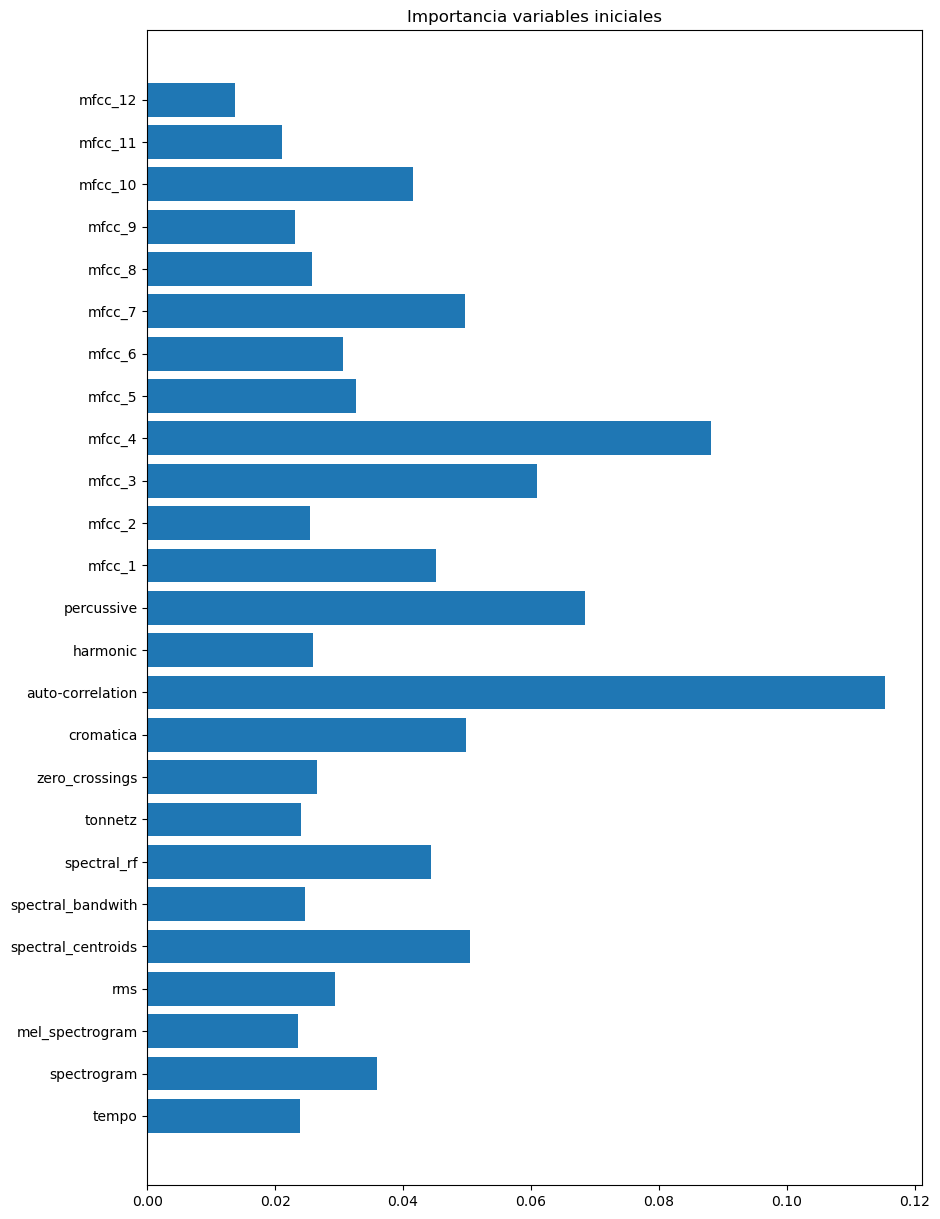

In [250]:
#Modelo Random Forest e importancia de las variables inicial.
rst = np.random.get_state()
np.random.set_state(rst)
from sklearn.ensemble import RandomForestClassifier
reg=RandomForestClassifier()
reg.fit(X = X_train, y = y_train)
plt.figure(figsize = (10,15))
plt.barh(reg.feature_names_in_,reg.feature_importances_)
plt.title('Importancia variables iniciales')

In [251]:
# Evaluacion conjunto de test modelo Random
from sklearn.metrics import accuracy_score
reg.score(X_test,y_test)


0.7666666666666667

In [252]:
# Validacion cruzada
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
rst = np.random.get_state()
np.random.set_state(rst)
y=df_t['Genero_label']
X=df_t[X_train.columns.to_list()]
cv = RepeatedKFold(n_splits=5, n_repeats=10)
scores = cross_validate(reg, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (np.mean(scores['test_score']), np.std(scores['test_score'])))

Accuracy: 0.675 (0.081)


In [5]:
# funcion para hacer combinacion de variables
from itertools import chain,combinations
def variables(list_name,n):
    s = list(list_name)
    val=chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    my_dict={}
    i=0
    for x in val:
        if len(x)>=n:
            my_dict[i]=list(x)
            i=i+1
    return my_dict

In [8]:
# fijamos los coeficientes de mel
fijas=X_train.iloc[:,13:25].columns.to_list()
my_dict=variables(X_train.iloc[:,0:14],3)

In [85]:
# busuqeda bruta de variables
import pyprind
resultado=pd.DataFrame()
bar=pyprind.ProgBar(len(my_dict),monitor=True, title='Buscando modelo..')
rst = np.random.get_state()
for key in my_dict:
    np.random.set_state(rst)
    X_train = df_train[my_dict[key]+fijas]
    y_train= df_train['Genero_label']
    X_test  = df_test[my_dict[key]+fijas]
    y_test  = df_test['Genero_label']
    #for clf in (r1,r2,r3):
    reg.fit(X_train,y_train)
    y=df_t['Genero_label']
    X=df_t[X_train.columns.to_list()]
    cv = RepeatedKFold(n_splits=5, n_repeats=10)
    scores = cross_validate(reg, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    new_df=pd.DataFrame({'name':str(reg),'score':reg.score(X_test,y_test),
                'var':[str(my_dict[key])], 'cv_score':np.mean(scores['test_score'])}, index=[0])
    resultado=pd.concat([resultado,new_df])
    bar.update(1)

Buscando modelo..
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 07:52:52


In [9]:
#establecer variables óptimas
col=fijas+['tempo', 'spectral_centroids', 'spectral_rf', 'auto-correlation','harmonic', 'percussive']

In [81]:
# busuqeda básica hiperparámetros
train={}
test={}
cross_v={}

rst = np.random.get_state()
for k in ['gini','entropy','log_loss']:
    t=[]
    tt=[]
    c=[]
    for i in range(2,100):
        np.random.set_state(rst)
        reg=RandomForestClassifier(criterion=k, max_depth=i,max_leaf_nodes=5, n_estimators=250)
        reg.fit(X_train[col],y_train)
        t.append(reg.score(X_train[col],y_train))
        tt.append(reg.score(X_test[col],y_test))
        cv = RepeatedKFold(n_splits=5, n_repeats=10)
        y=df_t['Genero_label']
        X=df_t[col]
        scores = cross_validate(reg, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
        c.append(np.mean(scores['test_score']))
        
    train[k]=t
    cross_v[k]=c
    test[k]=tt

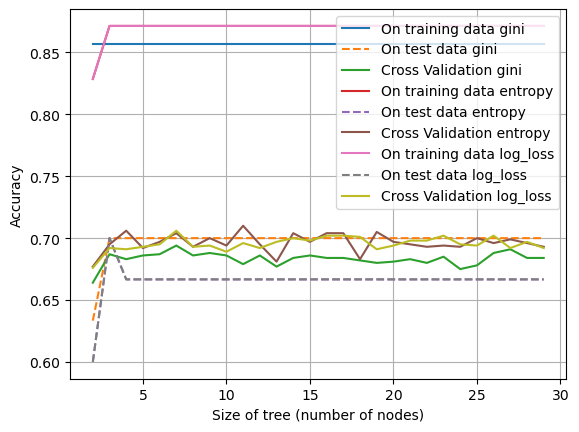

In [83]:
for k in ['gini','entropy','log_loss']:
    plt.plot(range(2,100),np.array(train[k]), label='On training data '+ k)
    plt.plot(range(2,100),np.array(test[k]) ,linestyle='dashed',label='On test data '+k)
    plt.plot(range(2,100),np.array(cross_v[k]) ,linestyle='solid',label='Cross Validation '+k)
    plt.xlabel('Size of tree (Depth)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

In [101]:
train=[]
test=[]
cross_v=[]
rst = np.random.get_state()
for i in range(2,100):
    np.random.set_state(rst)
    reg=RandomForestClassifier(criterion='entropy', max_depth=10,max_leaf_nodes=i, n_estimators=250)
    reg.fit(X_train[col],y_train)
    train.append(reg.score(X_train[col],y_train))
    test.append(reg.score(X_test[col],y_test))
    cv = RepeatedKFold(n_splits=5, n_repeats=10)
    y=df_t['Genero_label']
    X=df_t[col]
    scores = cross_validate(reg, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    cross_v.append(np.mean(scores['test_score']))

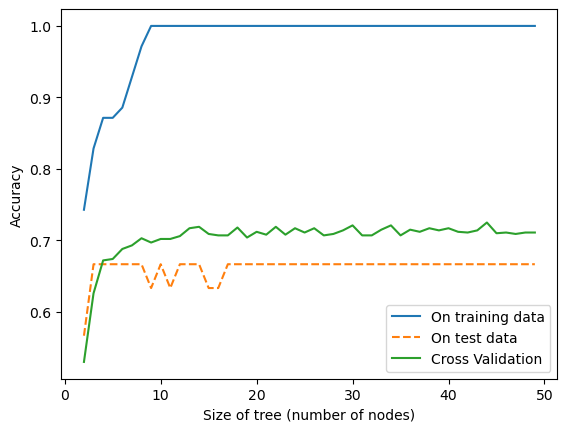

In [102]:
plt.plot(range(2,100),np.array(train), label='On training data')
plt.plot(range(2,100),np.array(test) ,linestyle='dashed',label='On test data')
plt.plot(range(2,100),np.array(cross_v) ,linestyle='solid',label='Cross Validation')
plt.xlabel('Size of tree (number of nodes)')
plt.ylabel('Accuracy')
plt.legend()

In [295]:
from sklearn.model_selection import GridSearchCV, RepeatedKFold
import multiprocessing


# ==============================================================================
param_grid = { 'n_estimators':[100,200,250],
              'criterion':['gini','entropy'],
              'max_features': ['auto','sqrt','log2'],
              'max_depth'   : [ 3, 5,7,10, 20,25],
              'max_leaf_nodes':[2,3,5,10]
              #'ccp_alpha':[0,0.01,0.02,0.03]
             }

# ==============================================================================
rst = np.random.get_state()
np.random.set_state(rst)
grid = GridSearchCV(
        
        estimator  = RandomForestClassifier(),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1, 
        refit      = True,
        cv = 20,#RepeatedKFold(n_splits=5, n_repeats=10),
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X[col], y = y)
print(grid.best_params_, ":", grid.best_score_, grid.scoring)
reg_cv = grid.best_estimator_

{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'max_leaf_nodes': 10, 'n_estimators': 100} : 0.7600000000000001 accuracy


In [380]:
idx=np.argmax(grid.cv_results_['mean_test_score'])
grid.cv_results_['params'][idx]

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'auto',
 'max_leaf_nodes': 10,
 'n_estimators': 100}

# Entrenamiento final e Implementación

In [131]:
# carga datos nuevos
df_new=pd.DataFrame()
i=0
for subcarpeta in os.listdir('Implement_data'):
    print("Procesando canciones de:", subcarpeta)
    for archivo in os.listdir('Implement_data/'+subcarpeta):
        if archivo.endswith('.mp3'):
            cancion='Implement_data/'+subcarpeta +'/'+archivo
            df=extrae_var(cancion)
            df['Genero_label']=i #genera una etiqueta numerica para entrenamiento de modelo
            df['Genero']=subcarpeta #genera etiqueta de nombre para las resententaciones
            df_new=pd.concat([df_new,df])
            
    i=i+1
df_new.reset_index(drop=True,inplace=True)

Procesando canciones de: jazz
Procesando canciones de: opera
Procesando canciones de: rap
Procesando canciones de: reggae
Procesando canciones de: rock


In [10]:
df_new=pd.read_pickle('implement_dataset.pkl')

In [11]:
#escalado de datos
df2=df_t.drop(['archivo','Genero','Genero_label'], axis=1).copy()
scaler=StandardScaler()
df_scaled=scaler.fit_transform(df2)
df_scaled=pd.DataFrame(df_scaled, columns=df2.columns.to_list())
df_scaled['archivo']=df_t['archivo']
df_scaled['Genero']=df_t['Genero']
df_scaled['Genero_label']=df_t['Genero_label'] 

X_train=df_scaled.drop(['archivo','Genero','Genero_label'], axis=1).copy()
y_train=df_scaled['Genero_label']




df2=df_new.drop(['archivo','Genero','Genero_label'], axis=1).copy()
df_scaled=scaler.transform(df2)
df_scaled=pd.DataFrame(df_scaled, columns=df2.columns.to_list())
df_scaled['archivo']=df_new['archivo']
df_scaled['Genero']=df_new['Genero']
df_scaled['Genero_label']=df_new['Genero_label'] 


X_test=df_scaled.drop(['archivo','Genero','Genero_label'], axis=1).copy()
y_test=df_scaled['Genero_label']


<BarContainer object of 18 artists>

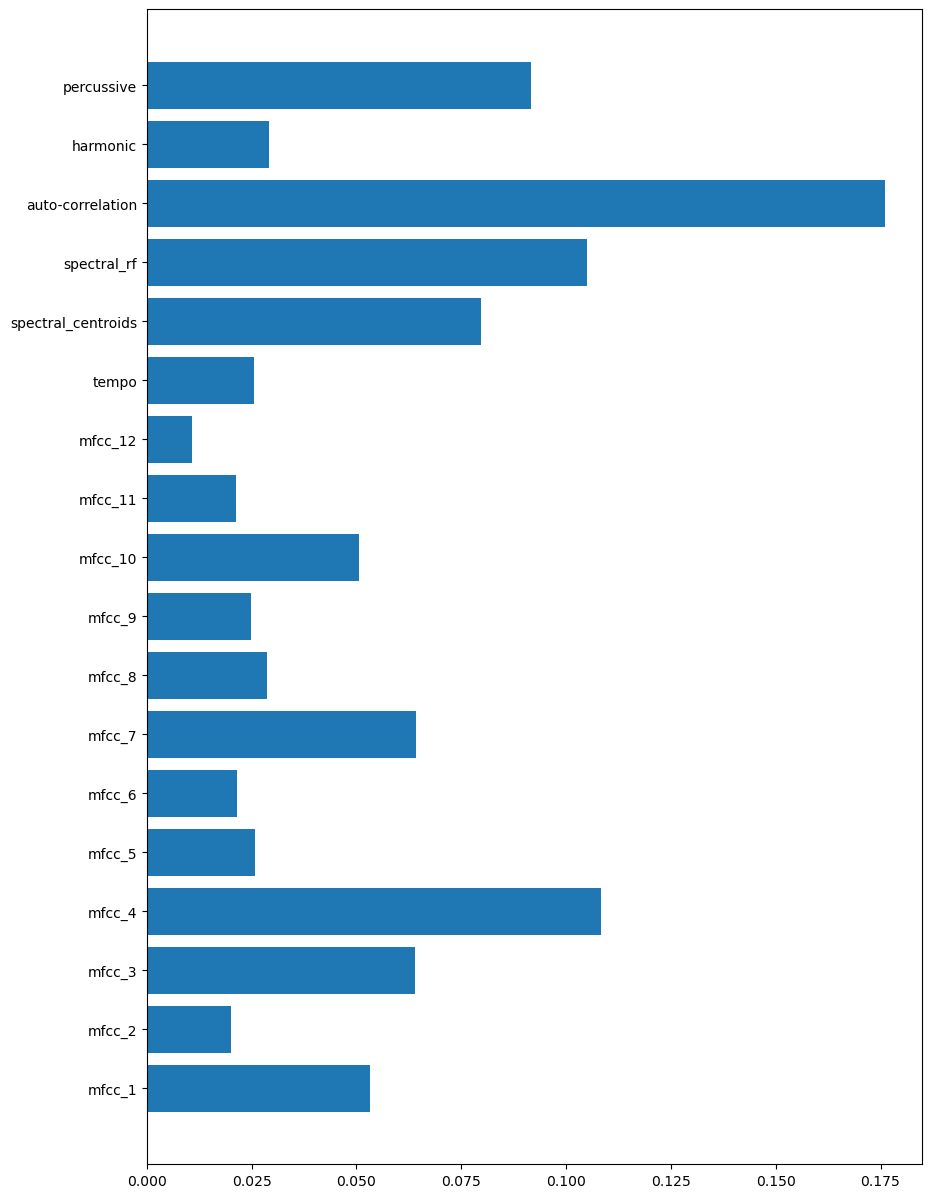

In [384]:
# Entrenamiento final con todas las observaciones antes de implementar
rst = np.random.get_state()
np.random.set_state(rst)
reg_cv.fit(X = X_train[col], y = y_train)
plt.figure(figsize = (10,15))
plt.barh(reg_cv.feature_names_in_,reg_cv.feature_importances_)


In [371]:
#guardamos modelo 
with open('RF_ProyectoAS2023.pkl','wb') as f:
    pickle.dump(reg_cv,f)

In [12]:
#cargamos modelo
with open('RF_ProyectoAS2023.pkl','rb') as f:
    model = pickle.load(f)

In [13]:
# Se implementa con las nuevas observaciones
pred=model.predict(X_test[col])
model.score(X_test[col],y_test)

0.7

In [14]:
pred

array([3, 2, 0, 0, 1, 1, 0, 1, 2, 2, 3, 2, 2, 4, 3, 3, 4, 4, 4, 4],
      dtype=int64)